In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Functions to generate multiple images

In [3]:
#FUnction that generates normal using points to a sphere. normal should be normalised
# Input takes in 3D structure coordinates, number of normal points
# Output array of 2D coordinates
def points_projection(structure_coords, num_points):

	# normal vector generation
    # input required(no of points)
    normal = set()
    radius = 1
    
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)
    
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)

    for i in range(len(x)):
        for j in range(len(x[i])):
            a = (round(x[i][j]),round(y[i][j]),round(z[i][j])) # group values of x, y, z
            #a = (x[i][j],y[i][j],z[i][j])
            normal.add(a)

	# projection part!!!
	# assign structure coords into z
    structure_coords = list(structure_coords)
    z = np.array(structure_coords)   
    
	
    all_projected_points = []
    
    for i in normal:
        n = np.array(i)
        
        #Find two orthogonal vectors u and v (both orthogonal to n)
        #Calc value for t (random vector), ensuring not a scaled version of n
        if n[0] != 0:
            t = np.array([-(n[1]+n[2]) / n[0], 1, 1])
        elif n[1] != 0:
            t = np.array([-(n[0]+n[2]) / n[1], 1, 1])
        else:
            t = np.array([-(n[0]+n[1]) / n[2], 1, 1])
        
        u = np.cross(t,n)
        v = np.cross(n,u)
        
        # Normalize u and v (vector length become 1 unit long)
        u = u / np.linalg.norm(u)
        v = v / np.linalg.norm(v)
        
        vec_mat = np.array([u,v])
        
        #Project structure points onto plane
        #Individual component of normal
        a = n[0]
        b = n[1]
        c = n[2]
        #d = 0 #component of equation of planes

        projected_points = []
        
        for point in z:
            z1, z2, z3 = point
            
            k = (0 - a*z1 - b*z2 - c*z3) / (a**2 + b**2 + c**2) 
            
            p1 = z1 + k*a
            p2 = z2 + k*b
            p3 = z3 + k*c
            
            p = np.array([p1,p2,p3])

            #Convert 3D points to 2D
            p_trans = p.transpose()
            proj_2d = np.dot(vec_mat,p_trans)
            projected_points.append(proj_2d)
            
        all_projected_points.append(projected_points)

    return np.array(all_projected_points)

# Function to transform projected 2D coordinates into images

In [5]:
# Transform projected points into image with 1s and 0s
def image_projection(coords, size):
    all_projects = np.array(coords)
    image_size = size

    all_images = []
    for projects in all_projects:
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projects, axis=0)
        max_val = np.max(projects, axis=0)
        
        #Feature scaling 
        points_norm = (projects - min_val) / (max_val - min_val) 
        
        # Scale points to image size
        points_scaled = (points_norm * (np.array(image_size) -1 )).astype(int)
        
        # Create an empty image
        image = np.zeros(image_size)
        
        # Populate the image with points
        for point in points_scaled:
            x, y = point
            image[y,x] = 1  # Note: (y, x) because image coordinates are row-major
        
        all_images.append(image)
        
        #Plot image
        plt.imshow(image, cmap='gray')
        plt.title('Projected Points Image')
        plt.show()
    
    return points_scaled

# Function that counts number of points within a cell by custom grid

In [7]:
#Place projected points into grid and count points per grid cell 
def cluster_per_cell(projected_points, image_size, grid_size):
    
    all_projections = np.array(projected_points)
    image_size = image_size
    grid_x = grid_size[0]
    grid_y = grid_size[1]
    
    #Calc size of grid cell
    cell_x = image_size[0] / grid_x
    cell_y = image_size[1] / grid_y

    for projection in all_projections:
        grid = np.zeros((grid_x,grid_y), dtype=int)
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projection, axis=0)
        max_val = np.max(projection, axis=0)
        
        #Feature scaling 
        points_norm = (projection - min_val) / (max_val - min_val) 
        
        scaled_points = (points_norm * (np.array(image_size) - 1)).astype(int)
        
        for points in scaled_points:
            x,y = points
            gridx_index = int(x // cell_x) #floor division followed by conversion to integer
            gridy_index = int(y // cell_y)
            grid[gridy_index, gridx_index] += 1
    
        # Plot the image and grid
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Draw the grid
        for row in range(grid_y + 1):
            ax.axhline(row * cell_y, color='black', linewidth=0.5)
        for col in range(grid_x + 1):
            ax.axvline(col * cell_x, color='black', linewidth=0.5)
        
        plt.gca().invert_yaxis()
    
        #Plot the points 
        ax.scatter(scaled_points[:,0], scaled_points[:,1], c="red", marker="." )
        
        #Plot numbers on grid
        for i in range(len(grid)):
            for j in range(len(grid)):
                ax.text( j * cell_y +(cell_y / 2), i * cell_x + (cell_x / 2), 
                        grid[i,j], fontsize = 20, color='blue', ha='center', va='center')
                
        
        #set axis labels
        ax.set_xlim(0 , image_size[1])
        ax.set_ylim(image_size[0], 0)
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title(f'Points Distribution with Grid Size: {image_size}')
        
       
        plt.show()

    return  grid

# TESTING

In [9]:
#Testing
#coords for a cube
coords = [(0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 1),  (0, 1, 1)]
no_of_normal = 3
image_size = (64,64)
grid_size = (10,10)

In [10]:
projects = points_projection(coords, no_of_normal)
print(projects)

[[[ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.70710678  0.70710678]
  [ 0.70710678  0.70710678]
  [-0.70710678  0.70710678]
  [-0.70710678  0.70710678]
  [ 0.          1.41421356]
  [ 0.          1.41421356]]

 [[ 0.          0.        ]
  [ 0.          0.        ]
  [-0.70710678  0.70710678]
  [-0.70710678  0.70710678]
  [ 0.70710678  0.70710678]
  [ 0.70710678  0.70710678]
  [ 0.          1.41421356]
  [ 0.          1.41421356]]

 [[ 0.          0.        ]
  [ 1.          0.        ]
  [ 1.          1.        ]
  [ 0.          1.        ]
  [ 0.          0.        ]
  [ 1.          0.        ]
  [ 1.          1.        ]
  [ 0.          1.        ]]

 [[ 0.          0.        ]
  [-1.          0.        ]
  [-1.          1.        ]
  [ 0.          1.        ]
  [ 0.          0.        ]
  [-1.          0.        ]
  [-1.          1.        ]
  [ 0.          1.        ]]]


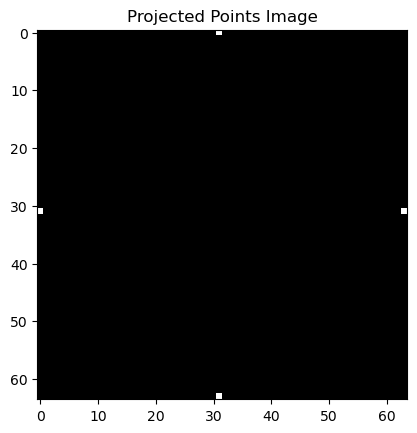

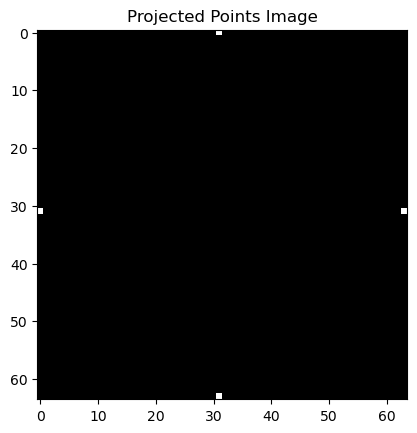

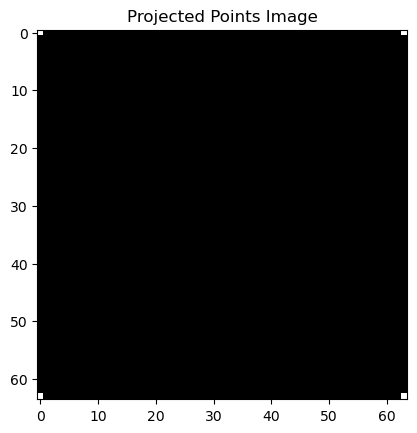

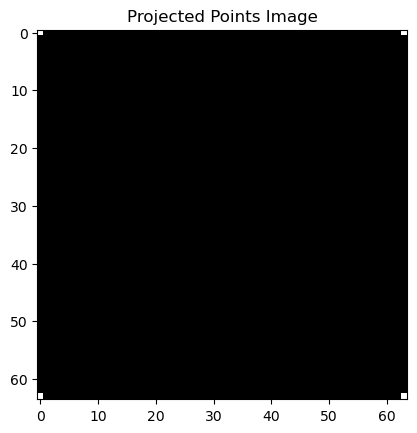

In [11]:
a = image_projection(projects, image_size)

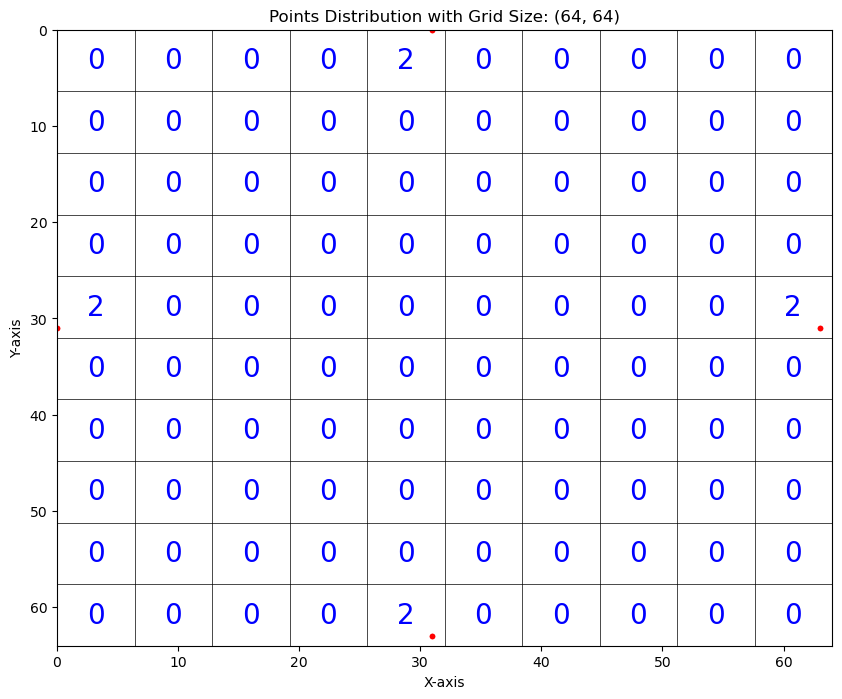

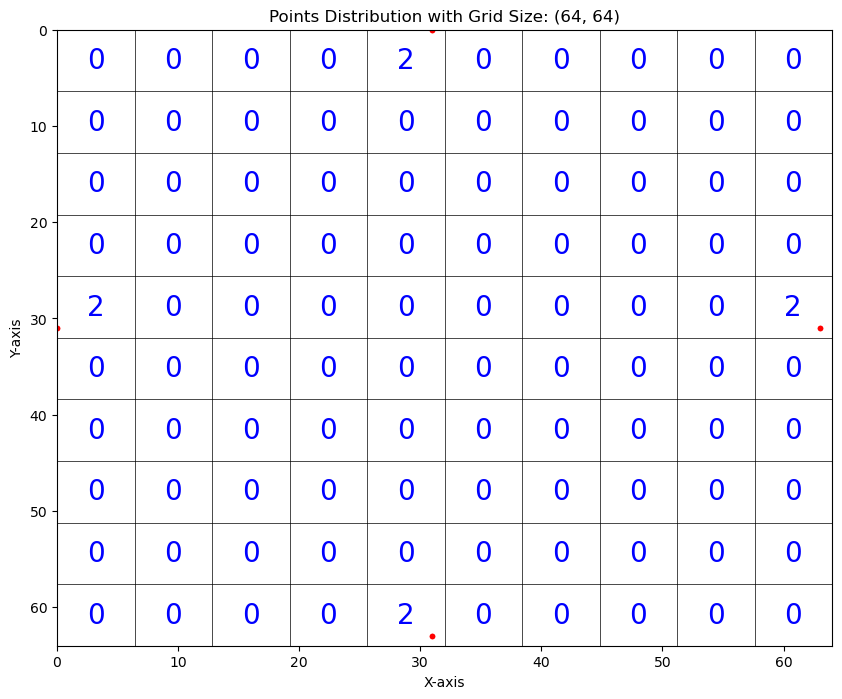

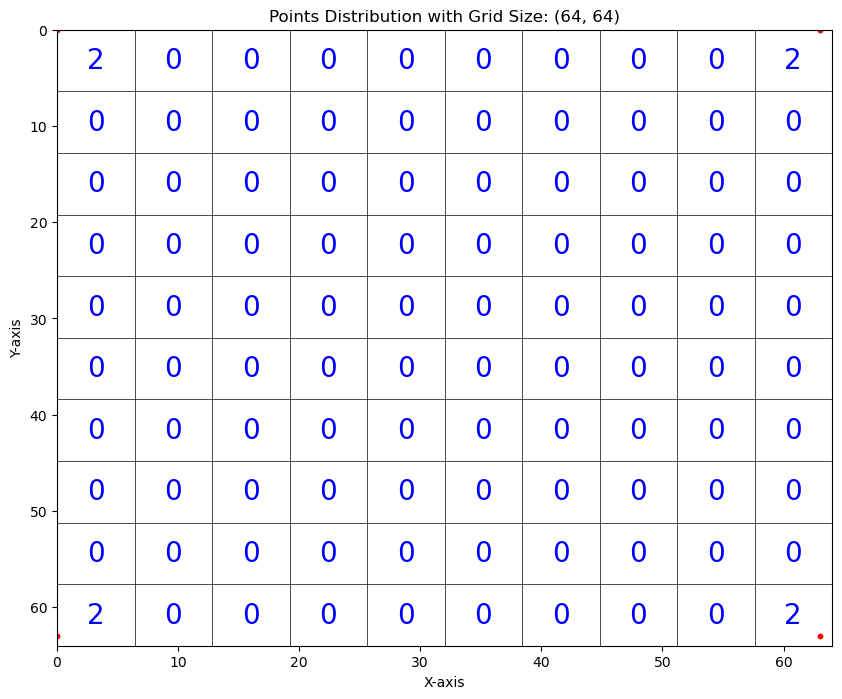

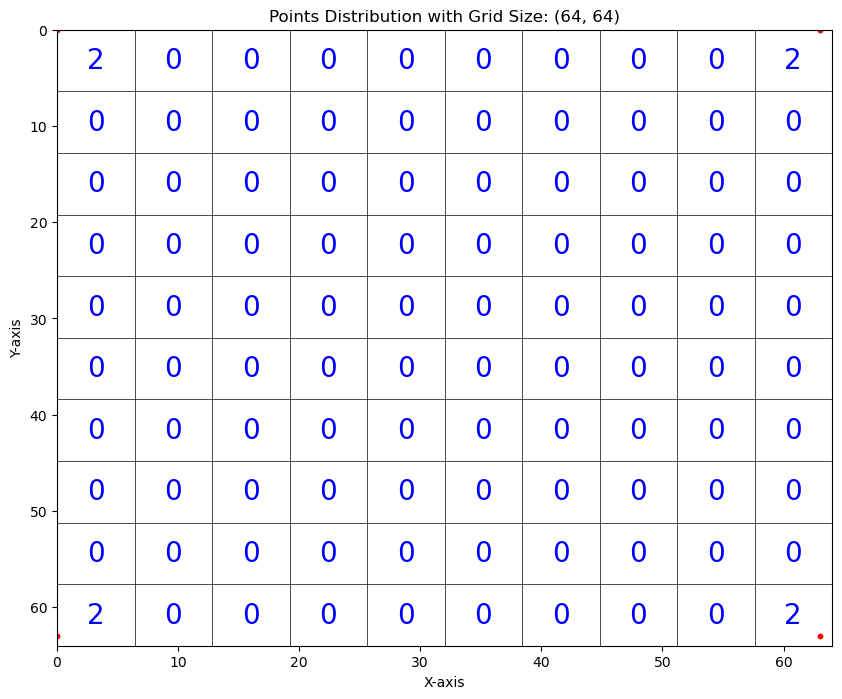

In [12]:
b = cluster_per_cell(projects,image_size, grid_size)